In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

In [2]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [3]:
num_aes = 2616
test_set = np.load('./data/test.npz')
test_inputs = np.squeeze(test_set['x'][0:num_aes])
inputs = test_inputs
print(f'Inputs: shape = {inputs.shape}, min = {np.min(inputs)}, max = {np.max(inputs)}')

Inputs: shape = (2616, 12, 150), min = 0.0, max = 11644.0


In [4]:
test_gts = np.squeeze(test_set['y'])
gts_test = test_gts
print(f'GTS: shape = {gts_test.shape}, min = {np.min(inputs)}, max = {np.max(gts_test)}')

GTS: shape = (2616, 12, 150), min = 0.0, max = 11644.0


In [5]:
test_op = np.load('./best_model/best_model_output.npz')
test_preds = np.squeeze(test_op['predictions'][0:2616])
print(f'shape = {test_preds.shape}, Max = {np.max(test_preds)}')
test_preds = test_preds*std + mean
print(f'shape = {test_preds.shape}, Max = {np.max(test_preds)}')

shape = (2616, 12, 150), Max = 3.3234169483184814
shape = (2616, 12, 150), Max = 11282.4541015625


In [6]:
fgsm_flow = np.load('./aes/adv_fgsm.npy', allow_pickle = True)
print(f'Inpts: shape= {fgsm_flow.shape}, Max = {np.max(fgsm_flow)}')
# They all need to be denormalized
fgsm_flow = fgsm_flow*std + mean
print(f'\nInputs: shape= {fgsm_flow.shape}, Max = {np.max(fgsm_flow)}')

Inpts: shape= (2616, 12, 150), Max = 3.490483283996582

Inputs: shape= (2616, 12, 150), Max = 11644.0


In [7]:
bim_flow = np.load('./aes/adv_bim.npy', allow_pickle = True)
print(f'Inpts: shape= {bim_flow.shape}, Max = {np.max(bim_flow)}')
# They all need to be denormalized
bim_flow = bim_flow*std + mean
print(f'\nInputs: shape= {bim_flow.shape}, Max = {np.max(bim_flow)}')

Inpts: shape= (2616, 12, 150), Max = 3.490483283996582

Inputs: shape= (2616, 12, 150), Max = 11644.0


In [8]:
fgsm_op = np.load('./data_fgsm/fgsm_gcgrnn_output.npz')
fgsm_preds = np.squeeze(fgsm_op['predictions'][0:2616])
print(f'Preds on AEs from test inputs: shape= {fgsm_preds.shape}, Max = {np.max(fgsm_preds)}')
fgsm_preds = fgsm_preds*std + mean
print(f'Preds on AEs from test inputs: shape= {fgsm_preds.shape}, Max = {np.max(fgsm_preds)}')

Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 3.5799195766448975
Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 11837.548828125


In [9]:
bim_op = np.load('./data_bim/bim_gcgrnn_output.npz')
bim_preds = np.squeeze(bim_op['predictions'][0:2616])
print(f'Preds on AEs from test inputs: shape= {bim_preds.shape}, Max = {np.max(bim_preds)}')
bim_preds = bim_preds*std + mean
print(f'Preds on AEs from test inputs: shape= {bim_preds.shape}, Max = {np.max(bim_preds)}')

Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 3.5044546127319336
Preds on AEs from test inputs: shape= (2616, 12, 150), Max = 11674.2353515625


In [10]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [11]:
# Error betn preds and gts
# Error on Orig
rmse_original, RMSE_collect_preds_on_inputs = get_metrics(test_preds, gts_test)
# Error on FGSM
rmse_fgsm, RMSE_collect_preds_on_fgsm = get_metrics(fgsm_preds, gts_test)
# Error on BIM
rmse_bim, RMSE_collect_preds_on_bim = get_metrics(bim_preds, gts_test)

In [113]:
np.argwhere(RMSE_collect_preds_on_fgsm>4*rmse_original)

array([[920],
       [944]], dtype=int64)

In [163]:
data_select = 920
node_select = 10

inpt = inputs[data_select,:,node_select]
gt = gts_test[data_select,:,node_select]

pred_on_orig = test_preds[data_select,:,node_select]

fgsm_ae = fgsm_flow[data_select,:,node_select]
bim_ae = bim_flow[data_select,:,node_select]

fgsm_pred = fgsm_preds[data_select,:,node_select]
bim_pred = bim_preds[data_select,:,node_select]

er_input = RMSE_collect_preds_on_inputs[data_select] # error is for the whole network wide
er_fgsm = RMSE_collect_preds_on_fgsm[data_select]
er_bim = RMSE_collect_preds_on_bim[data_select]

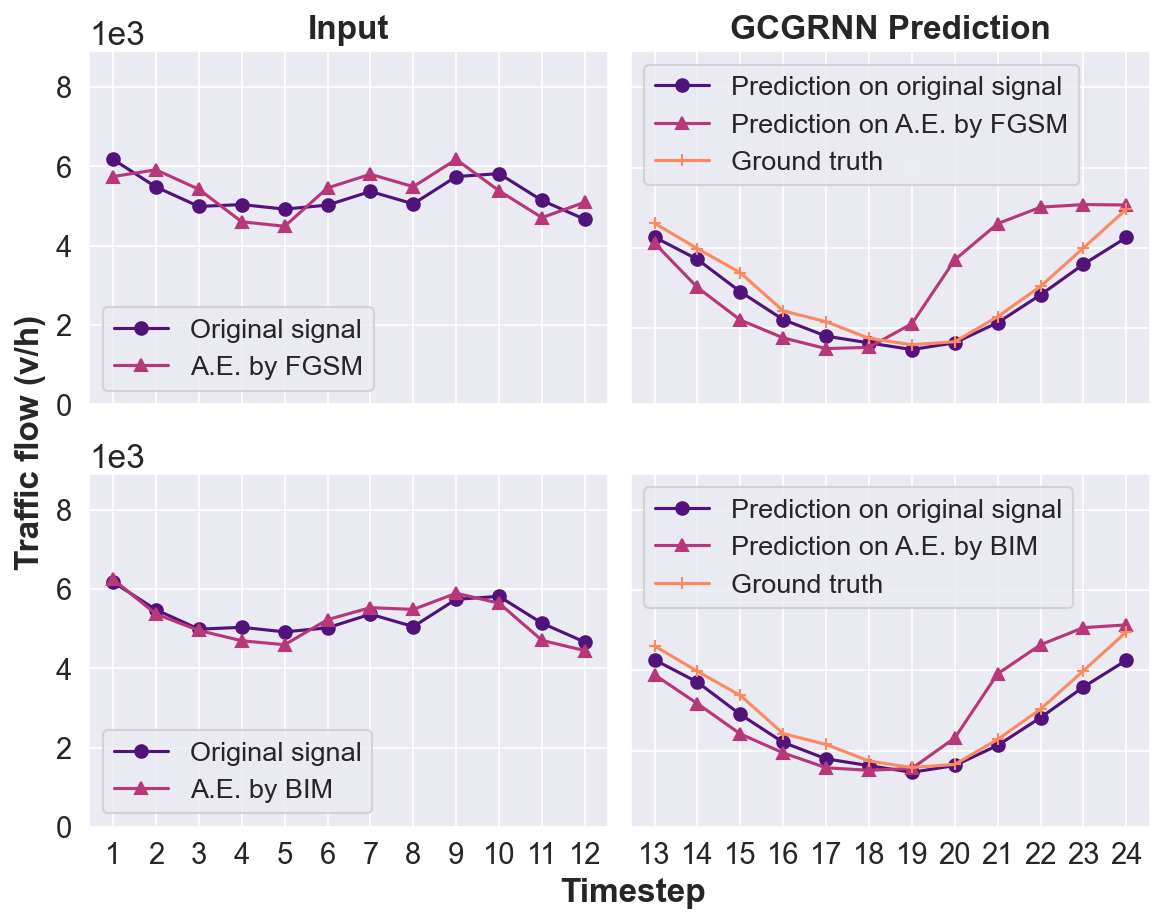

In [478]:
import matplotlib.font_manager as font_manager

total_x = np.arange(1,25,1)
x_pred = np.arange(13,25,1)
x_inpt = np.arange(1,13,1)

y_tks = np.arange(0, 9000, 2000)

#legend_first=["Original Input", "Adversarial example from FGSM", "Adversarial example from BIM"]
legend_first=["Original signal", "A.E. by FGSM"]
legend_second=["Original signal", "A.E. by BIM"]
a = 500*np.ones(12)

legend_third=["Prediction on original signal", "Prediction on A.E. by FGSM", "Ground truth"]
legend_fourth=["Prediction on original signal", "Prediction on A.E. by BIM", "Ground truth"]
b = 8500*np.ones(12)

sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

with plt.rc_context({"ytick.major.pad": 5}):
    fs = 14
    #var = 6
    legend_font = font_manager.FontProperties(family=None,
                                   style='normal', size=fs-1)
    
    fig, ax = plt.subplots(2,2,figsize=(8,6), dpi=150, sharex='col', sharey=True)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
    
    plt.ticklabel_format(axis="y", style='sci', scilimits=(0,1))

    fig.text(0.5, -0.01, "Timestep", ha='center', fontsize=fs+2, fontweight="bold")
    fig.text(-0.015, 0.5, "Traffic flow (v/h)", va='center', rotation='vertical',fontsize=fs+2, fontweight="bold")

    ax[0][0].plot(x_inpt,inpt,marker='o')
    ax[0][0].plot(x_inpt,fgsm_ae,marker='^')
    ax[0][0].plot(x_inpt,a, alpha=0.)
    ax[0][0].legend(legend_first, loc='lower left',prop=legend_font)
    ax[0][0].set_title("Input",fontsize=fs+2, fontweight="bold")

    ax[1][0].plot(x_inpt,inpt,marker='o')
    ax[1][0].plot(x_inpt,bim_ae,marker='^')
    ax[1][0].plot(x_inpt,a, alpha=0.)
    ax[1][0].legend(legend_second, loc='lower left',prop=legend_font)

    ax[0][1].plot(x_pred,pred_on_orig,marker='o')
    ax[0][1].plot(x_pred,fgsm_pred,marker='^')
    ax[0][1].plot(x_pred,gt,marker='+')
    ax[0][1].plot(x_pred,b, alpha=0.)
    ax[0][1].legend(legend_third, loc='upper left',prop=legend_font)
    ax[0][1].set_title("GCGRNN Prediction",fontsize=fs+2, fontweight="bold")
    
    ax[1][1].plot(x_pred,pred_on_orig,marker='o')
    ax[1][1].plot(x_pred,bim_pred,marker='^')
    ax[1][1].plot(x_pred,gt,marker='+')
    ax[1][1].plot(x_pred,b, alpha=0.)
    ax[1][1].legend(legend_fourth, loc='upper left', prop=legend_font)

    ax[1][0].set_xticks(x_inpt);
    ax[1][1].set_xticks(x_pred);
    ax[0][0].set_yticks(y_tks);
    ax[1][0].set_yticks(y_tks);

    #ax[1][1].set_xticklabels(x_pred, fontsize=12);
    ax[0][0].tick_params(axis='both', which='major', labelsize=fs) 
    ax[0][0].tick_params(axis='both', which='minor', labelsize=fs)
    ax[1][0].tick_params(axis='both', which='major', labelsize=fs) 
    ax[1][0].tick_params(axis='both', which='minor', labelsize=fs)
    ax[1][1].tick_params(axis='both', which='major', labelsize=fs) 
    ax[1][1].tick_params(axis='both', which='minor', labelsize=fs)

    fig.tight_layout()

## RMSE distribution

In [454]:
import pandas as pd

# Load inputs
orig_dstr = np.load("./common_viz/dstr_orig.npy",allow_pickle = True)
fgsm_dstr = np.load("./common_viz/dstr_fgsm.npy",allow_pickle = True)
bim_dstr = np.load("./common_viz/dstr_bim.npy",allow_pickle = True)

dstr_data = np.array([bim_dstr, fgsm_dstr, orig_dstr])
df = pd.DataFrame({'bim': dstr_data[2,:], 'fgsm': dstr_data[1,:], 'orig': dstr_data[0,:]})
df.shape

(2616, 3)

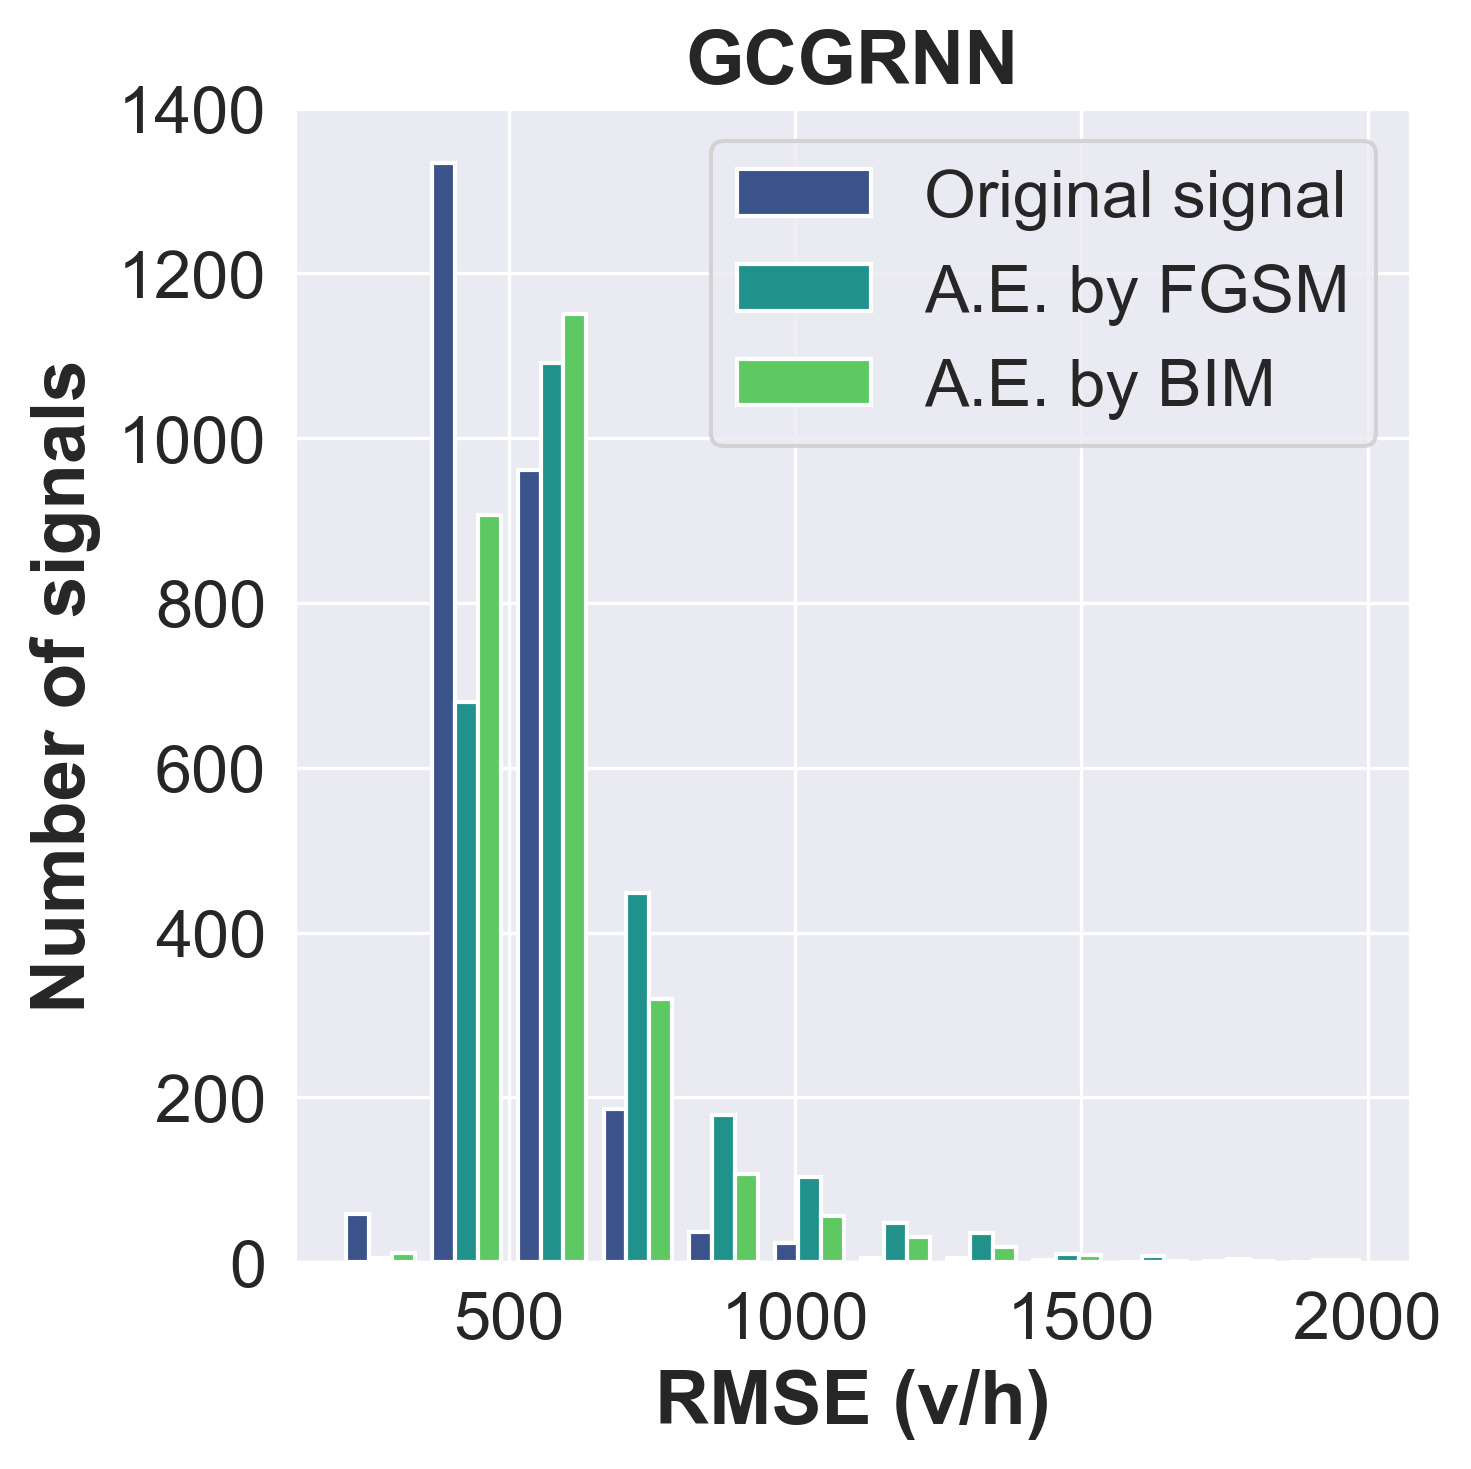

In [460]:
fs = 18

plt.rc('xtick', labelsize=fs-2) 
plt.rc('ytick', labelsize=fs-2) 

sns.set_palette(palette='viridis', n_colors=3)

sns.set_palette(palette='viridis', n_colors=3)

n_bins = 12
x = df.values

fig, axes = plt.subplots(figsize=(5,5),dpi=300)
colors = df.columns
axes.hist(x, n_bins, density=False, histtype='bar', range=(200,2000), label=colors)

axes.set_title("GCGRNN", fontweight='bold',fontsize=fs)
labels =["Original signal","A.E. by FGSM","A.E. by BIM"]
axes.legend(labels, fontsize=fs-2)
axes.set_xlabel('RMSE (v/h)', fontweight='bold', fontsize=fs)
axes.set_ylabel('Number of signals', fontweight='bold', fontsize=fs);
fig.tight_layout()